In [1]:
#Importing libraries

import numpy as np
import copy
from matplotlib import pyplot as plt
import scipy
from scipy.integrate import solve_ivp #This one does all the work
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Declaring constants

B_0=0.5*4*10**(-5)
#B_0 = 0.2*0.0366*0.5
y_0=10**4
a=6.5*10**(-3)
alpha=2.5
T_0=290
m=106
omega=7.29*10**(-5) #jordens rotasjonshastighet
R = 6.371e6
G = 5.972*10**(24)*6.67*10**(-11)

In [27]:
#Set of coordinates

# start = [89,0,0,0,0,0]
# end = [1,0,0,0,0,0]
start=np.array([49,36,18,3,30,53]) #Crépy
end =np.array([48,51,24,2,21,3]) #Paris
# end = np.array([-48, -51, -24, -177, -38, -7]) #Pacific ocean
# end = np.array([63, 26, 48, 10, 25, 18]) #Trondheim
# start = np.array([59, 54, 40, 10, 44, 0]) #Oslo
# end = np.array([78, 0, 0, 16, 0, 0]) #Svalbard
# end = np.array([60, 18, 21, 5, 2, 44.6]) #Hytten
# start = [41,0,28.7, 28, 58, 49.6] #Hagia Sofia
# end = [38, 53, 52, -77, -2, -11] #The White House


In [4]:
#Implementing functions

def direction(start_loc, end_loc):
    #From DMS to float degrees
    x_end=end_loc[0]+end_loc[1]/60+end_loc[2]/3600
    x_start=start_loc[0]+start_loc[1]/60+start_loc[2]/3600
    y_end=end_loc[3]+end_loc[4]/60+end_loc[5]/3600
    y_start=start_loc[3]+start_loc[4]/60+start_loc[5]/3600
    
    #Degrees to radians
    endradx = x_end*np.pi/180
    startradx = x_start*np.pi/180
    endrady = y_end*np.pi/180
    startrady = y_start*np.pi/180
    
    #Polar coordinates to cartesian
    x0 = R*np.sin(startradx)
    y0 = R*np.cos(startradx)*np.sin(startrady)
    z0 = R*np.cos(startradx)*np.cos(startrady)
    
    x1 = R*np.sin(endradx)
    y1 = R*np.cos(endradx)*np.sin(endrady)
    z1 = R*np.cos(endradx)*np.cos(endrady)  
    
    #Length between start and end
    initialR = np.sqrt((x1-x0)**2 + (y1-y0)**2 + (z1-z0)**2)
    
    #Rotated towards east
    x2 = x1
    y2 = np.cos(startrady)*y1 - np.sin(startrady)*z1
    z2 = np.sin(startrady)*y1 + np.cos(startrady)*z1
    
    #Rotated towards south
    x3 = np.cos(startradx)*x2 - np.sin(startradx)*z2
    y3 = y2
    z3 = np.sin(startradx)*x2 + np.cos(startradx)*z2 - R
    #This is the final position.
    
    #Ground angel, directly south = 0
    theta = np.arctan2(y3, -x3)
    
    return theta, startradx, startrady, (y_start, x_start), (y_end, x_end), (y3, x3, z3), initialR, (x0, y0, z0), (x1, y1, z1)

#Finds error in ground angle
def errorTheta(initialTheta, x, y):
    return np.abs(initialTheta - np.arctan2(y, x))
    
#Finds radial error
def errorR(initialR, x, y, z):
    return np.abs(initialR - np.sqrt(x**2 + y**2 + z**2))

#Tests if projectile lands
def didLand(x, y, z):
    return np.sqrt(x**2 + y**2 + (z+R)**2) <= R + 2

#Converts coordinates from cartesian to global
def cartToPolar(beta, gamma, x1, y1, z1):
    z1 += R
    x1 *= -1
    
    #Rotated towards south
    x2 = np.cos(beta)*x1 + np.sin(beta)*z1
    y2 = y1
    z2 = -np.sin(beta)*x1 + np.cos(beta)*z1
    
    #Rotated towards east
    x3 = x2
    y3 = np.cos(gamma)*y2 + np.sin(gamma)*z2
    z3 = -np.sin(gamma)*y2 + np.cos(gamma)*z2
    
    øst = 180/np.pi*np.arctan2(y3,z3)
    nord = 180/np.pi*np.arctan2(x3, np.sqrt(y3**2+z3**2))    
    return nord, øst, (x3, y3, z3)

#Finds radius from earth's centre
def length(south, east, up):
    return np.sqrt(south**2 + east**2 + (up+R)**2)

#Function used for getting excact values where projectile lands
def hitGround(t, y):
    return np.sqrt(y[0]**2 + y[1]**2 + (y[2] + R)**2) - R
    
hitGround.terminal = False #Whether computations should stop or continue when projectile reaches ground
    
#Computes elementwise gravitational accelaration
def gravity(radi, radii):
    return -G*radii/(radi**3)
    
#Computes general part of air resistance
def general_part(z, v_x, v_y, v_z):
    must_be_positive=1-a*z/T_0
    if must_be_positive<0:
        return 0
    if z < 0:
        return 0
    return B_0*(must_be_positive**alpha)*np.sqrt(v_x**2+v_y**2+v_z**2)

#Computes elementwise air resistance
def a_adi(product, v_q):
    return -1*product*v_q

#Function for dy/dt
def k(t, w):
    global x_0, y_0, z_0, beta
    radi = length(w[0],w[1],w[2])
    B_V_product=general_part(radi-R, w[3], w[4], w[5])
    
    newW = copy.copy(w)
    newW[0]=w[3]
    newW[1]=w[4]
    newW[2]=w[5]
    newW[3]= gravity(radi, w[0]) + a_adi(B_V_product,w[3])+2*w[4]*omega*np.sin(beta)
    newW[4]= gravity(radi, w[1]) + a_adi(B_V_product,w[4])-2*(w[3]*np.sin(beta)+w[5]*np.cos(beta))*omega
    newW[5]= gravity(radi, w[2]+R) + a_adi(B_V_product,w[5])+2*w[4]*omega*np.cos(beta)
    return newW

In [29]:
#main

#Single simulation shooting straight towards target
def simulation1(phi, v_0, start_loc, end_loc, tEnd, N):
    global x_0, y_0, z_0, beta 
    theta, beta, gamma, startP, endP, endC, initialR, cartStart, cartEnd = direction(start_loc, end_loc) #Getting start directions
    v_x_0= v_0*np.cos(phi)*np.cos(theta) #Computing initial velocity
    v_y_0=v_0*np.cos(phi)*np.sin(theta)
    v_z_0=v_0*np.sin(phi)
    x_0, y_0, z_0, = 0, 0, 1 #Initial position
    sol = solve_ivp(k, [0, tEnd], [0, 0, 1, v_x_0, v_y_0, v_z_0], method='RK45', vectorized=False, rtol = 1e-9, atol = 1e-9 , dense_output=True, events = hitGround) #This is where the projectile motion is computed
    t = np.linspace(0, tEnd, N) 
    z = sol.sol(t) #Trajectory
    tLand = sol.t_events #Time of impact
    landed = len(tLand[0]) #Boolean value for landed or not
    L = length(z[0], z[1], z[2]) #Radius from earth's centre
    if not landed and tEnd < 100000: #Test for wheter tEnd was sufficient or if another attempt should be made
        return simulation1(phi, v_0, start_loc, end_loc, tEnd*2, N*2) #Another attempt
    elif landed:
        zLand = sol.sol(tLand[0][0]) #Landing point
        trunc = np.where(L<=R)[0][0]+1 #Truncates trajectory at landing point
        t, z = t[:trunc], z[:,:trunc]
        z[0, -1] = zLand[0] #Adds excact landing point
        z[1, -1] = zLand[1]
        z[2, -1] = zLand[2]
        z[3, -1] = zLand[3]
        z[4, -1] = zLand[4]
        z[5, -1] = zLand[5]
        t[-1] = tLand[0][0]
    cop = copy.copy(z) #Copying lists for coordinate conversion
    sør, øst, cart = cartToPolar(beta, gamma, cop[0], cop[1], cop[2])
    L = length(z[0], z[1], z[2])
    return t, z, L, sør, øst, startP, endP, endC

#Single simulation shooting at given ground angle
def simulation2(phi, theta, v_0, tEnd, N):
    global x_0, y_0, z_0, beta, gamma
    v_x_0= v_0*np.cos(phi)*np.cos(theta) #Computing initial velocity
    v_y_0=v_0*np.cos(phi)*np.sin(theta)
    v_z_0=v_0*np.sin(phi)
    x_0, y_0, z_0, = 0, 0, 1 #Initial position
    sol = solve_ivp(k, [0, tEnd], [0, 0, 1, v_x_0, v_y_0, v_z_0], method='RK45', vectorized=False, rtol = 1e-9, atol = 1e-9 , dense_output=True, events = hitGround) #This is where the projectile motion is computed
    t = np.linspace(0, tEnd, N)
    z = sol.sol(t) #Trajectory
    tLand = sol.t_events #Time of impact
    landed = len(tLand[0]) #Boolean value for landed or not
    L = length(z[0], z[1], z[2]) #List of radius from earth's centre
    if not landed and tEnd < 100000:  #Test for wheter tEnd was sufficient or if another attempt should be made
        return simulation2(phi, theta, v_0, tEnd*2, N*2) #Another attempt
    elif landed:
        zLand = sol.sol(tLand[0][0]) #Landing point
        trunc = np.where(L<=R)[0][0]+1 #Truncates trajectory at landing point
        t, z = t[:trunc], z[:,:trunc]
        z[0, -1] = zLand[0] #Adds excact landing point
        z[1, -1] = zLand[1]
        z[2, -1] = zLand[2]
        z[3, -1] = zLand[3]
        z[4, -1] = zLand[4]
        z[5, -1] = zLand[5]
        t[-1] = tLand[0][0]
    return t, z

#Function for finding a ground angle and z angle which leads to sufficiently low error in radial and asimuthal direction
def optimization(v_0, start_loc, end_loc, tEnd, N, uR, uTheta, dTheta, dPhi, phi, thetaAdjust):
    global beta, gamma
    theta, beta, gamma, startP, endP, endC, initialR, cartStart, cartEnd = direction(start_loc, end_loc) #Getting inital directions
    initialTheta = theta #To compare for errors
    theta += thetaAdjust #In case a biased initial direction is wanted
    dPhi1 = dPhi #Standard angular difference in z direction
    dTheta1 = dTheta #Standard angular difference in z direction
    t, z = simulation2(phi, theta, v_0, tEnd, N) #First simulation
    tLand = t[-1] #Time of impact
    if not didLand(z[0, -1], z[1, -1], z[2, -1]): #In case projectile escapes earth's gravitational field
        print("Error: Projectile did not land.")
        return 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
    errR = errorR(initialR, z[0, -1], z[1, -1], z[2, -1]) #Initial error in radial direction
    errTheta = errorTheta(initialTheta, z[0, -1], z[1, -1]) #Initial error in azimuthal direction
    while errR > uR or errTheta > uTheta: #Loop while errors are too large
        if errR > uR: #If radial error is too large, improve this one first
            phiPlus = phi + dPhi #Tests both + and - given difference
            phiMinus = phi - dPhi
            tPlus, zPlus = simulation2(phiPlus, theta, v_0, tLand*1.05, N) #Simulates both cases
            tMinus, zMinus = simulation2(phiMinus, theta, v_0, tLand*1.05, N)
            errorRPlus = errorR(initialR, zPlus[0, -1], zPlus[1, -1], zPlus[2, -1]) #Computes both errors
            errorRMinus = errorR(initialR, zMinus[0, -1], zMinus[1, -1], zMinus[2, -1])
            if errorRPlus <= errorRMinus and errorRPlus < errR: #Chose smallest error, only if the errors are smaller than previous error
                errR = errorRPlus 
                phi = phiPlus #Set this angle as the new and update error
                errTheta = errorTheta(initialTheta, zPlus[0, -1], zPlus[1, -1])
                dTheta = dTheta1
                tLand = tPlus[-1] #Update ladning time
            elif errorRMinus <= errorRPlus and errorRMinus < errR:
                errR = errorRMinus
                phi = phiMinus #Set this angle as the new and update error
                errTheta = errorTheta(initialTheta, zMinus[0, -1], zMinus[1, -1])
                dTheta = dTheta1
                tLand = tMinus[-1] #Update landing time
            else:
                dPhi *= 0.2 #If no errors are smaller, decrease angle difference
        else: #If radial error is sufficiently small, improve azimuthal error
            thetaPlus = theta + dTheta #Tests both + and - given difference
            thetaMinus = theta - dTheta
            tPlus, zPlus = simulation2(phi, thetaPlus, v_0, tLand*1.05, N) #Simulates both cases
            tMinus, zMinus = simulation2(phi, thetaMinus, v_0, tLand*1.05, N)
            errorThetaPlus = errorTheta(initialTheta, zPlus[0, -1], zPlus[1, -1]) #Computes both errors
            errorThetaMinus = errorTheta(initialTheta, zMinus[0, -1], zMinus[1, -1])
            if errorThetaPlus <= errorThetaMinus and errorThetaPlus < errTheta: #Chose smallest error, only if the errors are smaller than previous error
                errTheta = errorThetaPlus
                theta = thetaPlus #Set this angle as the new and update error
                errR = errorR(initialR, zPlus[0, -1], zPlus[1, -1], zPlus[2, -1])
                dPhi = dPhi1
                tLand = tPlus[-1] #Update ladning time
            elif errorThetaMinus <= errorThetaPlus and errorThetaMinus < errTheta:
                errTheta = errorThetaMinus
                theta = thetaMinus #Set this angle as the new and update error
                errR = errorR(initialR, zMinus[0, -1], zMinus[1, -1], zMinus[2, -1])
                dPhi = dPhi1
                tLand = tMinus[-1] #Update landing time
            else:
                dTheta *= 0.2 #If no errors are smaller, decrease angle difference
        print("Error in radius:", errR, "Error in angles:", errTheta*180/np.pi, "Angles:", phi*180/np.pi, "t:", tLand)
    tFinal, zFinal = simulation2(phi, theta, v_0, tLand*1.05, N) #Final simulation which sufficiates error demands
    cop1 = copy.copy(zFinal) #Copying lists for coordinate conversion
    sørFinal, østFinal, cartFinal = cartToPolar(beta, gamma, cop1[0], cop1[1], cop1[2]) #Convert to global coordinates
    LFinal = length(zFinal[0], zFinal[1], zFinal[2]) #Compute radius from earth's centre
    print("Vinkeljustering:", (theta - initialTheta)*180/np.pi)
    return startP, endP, endC, cartStart, cartEnd, theta, phi, tFinal, zFinal, cartFinal, LFinal, sørFinal, østFinal, errR, errTheta

#Function for finding a ground angle and z angle which leads to sufficiently low error in radial and asimuthal direction
def optimization2(v_0, start_loc, end_loc, tEnd, N, uR, uTheta, dTheta, dPhi, phi, thetaAdjust):
    global beta, gamma
    theta, beta, gamma, startP, endP, endC, initialR, cartStart, cartEnd = direction(start_loc, end_loc) #Getting inital directions
    initialTheta = theta #To compare for errors
    theta += thetaAdjust #In case a biased initial direction is wanted
    dPhi1 = dPhi #Standard angular difference in z direction
    dTheta1 = dTheta #Standard angular difference in z direction
    t, z = simulation2(phi, theta, v_0, tEnd, N) #First simulation
    tLand = t[-1] #Time of impact
    if not didLand(z[0, -1], z[1, -1], z[2, -1]): #In case projectile escapes earth's gravitational field
        print("Error: Projectile did not land.")
        return 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
    errR = errorR(initialR, z[0, -1], z[1, -1], z[2, -1]) #Initial error in radial direction
    errTheta = errorTheta(initialTheta, z[0, -1], z[1, -1]) #Initial error in azimuthal direction
    while errR > uR or errTheta > uTheta: #Loop while errors are too large
#         if errTheta/uTheta > errR/uR: #Improve which relative error is largest
        if errTheta > uTheta: #If azimuthal error is largest improve this one first
            thetas = np.linspace(theta + dTheta, theta - dTheta, 10)
            errorThetas = np.zeros(10)
            errorPhis = np.zeros(10)
            timeThetas = np.zeros(10)
            for i in range(10):
                tTest, zTest = simulation2(phi, thetas[i], v_0, tLand*1.05, N)
                errorThetas[i] = errorTheta(initialTheta, zTest[0, -1], zTest[1, -1])
                errorPhis[i] = errorR(initialR, zTest[0, -1], zTest[1, -1], zTest[2, -1])
                timeThetas[i] = tTest[-1]
            lowestError = np.amin(errorThetas)
            lowestInd = np.argmin(errorThetas)
            if lowestError < errTheta:
                theta = thetas[lowestInd]
                errTheta = lowestError
                errR = errorPhis[lowestInd]
                dPhi = dPhi1
                tLand = timeThetas[lowestInd]
                if lowestInd%9 != 0:
                    dTheta *= 0.25    
            else:
                dTheta *= 0.25 #If no errors are smaller, decrease angle difference
        else:
            phiMinus = phi - dPhi
            if phiMinus <=0:
                phiMinus = 1e-7
            phis = np.linspace(phi + dPhi, phiMinus, 10)
            errorPhis = np.zeros(10)
            errorThetas = np.zeros(10)
            timePhis = np.zeros(10)
            for i in range(10):
                tTest, zTest = simulation2(phis[i], theta, v_0, tLand*1.05, N)
                errorPhis[i] = errorR(initialR, zTest[0, -1], zTest[1, -1], zTest[2, -1])
                errorThetas[i] = errorTheta(initialTheta, zTest[0, -1], zTest[1, -1])
                timePhis[i] = tTest[-1]
            lowestError = np.amin(errorPhis)
            lowestInd = np.argmin(errorPhis)
            if lowestError < errR:
                phi = phis[lowestInd]
                errR = lowestError
                errTheta = errorThetas[lowestInd]
                dTheta = dTheta1
                tLand = timePhis[lowestInd]
                if lowestInd%9 != 0:
                    dPhi *= 0.25    
            else:
                dPhi *= 0.25 #If no errors are smaller, decrease angle difference
        print("Error in radius:", errR, "Error in angles:", errTheta*180/np.pi, "Angles:", phi*180/np.pi, "t:", tLand)
    tFinal, zFinal = simulation2(phi, theta, v_0, tLand*1.05, N) #Final simulation which sufficiates error demands
    cop1 = copy.copy(zFinal) #Copying lists for coordinate conversion
    sørFinal, østFinal, cartFinal = cartToPolar(beta, gamma, cop1[0], cop1[1], cop1[2]) #Convert to global coordinates
    LFinal = length(zFinal[0], zFinal[1], zFinal[2]) #Compute radius from earth's centre
    print("Vinkeljustering:", (theta - initialTheta)*180/np.pi)
    return startP, endP, endC, cartStart, cartEnd, theta, phi, tFinal, zFinal, cartFinal, LFinal, sørFinal, østFinal, errR, errTheta


In [30]:
#Crunch numbers
# tFinal, zFinal, LFinal, nordFinal, østFinal, startP, endP, endC = simulation1(45*np.pi/180, 1000, start, end, 5000, 10000)

startP, endP, endC, cartStart, cartEnd, theta, phi, tFinal, zFinal, cartFinal, LFinal, nordFinal, østFinal, errR, errTheta = optimization2(1640, start, end, 1000, 5000, 0.1, 1e-6, 1, 15*np.pi/180, 55*np.pi/180, 0)
# startP, endP, endC, theta, phi, tFinal, zFinal, LFinal, nordFinal, østFinal, errR, errTheta = optimization1(16500, start, end, 20000, 5000, 10000, 0.01, 1.2, 0.5*np.pi/180, 25*np.pi/180, 0)

# v_0, start_loc, end_loc, tEnd, N, uR, uTheta, dTheta, dPhi, phi, PhiMin

Error in radius: 25208.452222973225 Error in angles: 0.8377433006723491 Angles: 55.0 t: 212.83165273356104
Error in radius: 25214.62046805941 Error in angles: 0.7485675235804939 Angles: 55.0 t: 212.85902727088597
Error in radius: 25213.06188424508 Error in angles: 0.35197707593858935 Angles: 55.0 t: 212.8521104811423
Error in radius: 25211.90013620979 Error in angles: 0.054539845630096215 Angles: 55.0 t: 212.84695473627735
Error in radius: 25211.610666640452 Error in angles: 0.019818714783175605 Angles: 55.0 t: 212.84567008361108
Error in radius: 25211.682997675816 Error in angles: 0.0012291026369189867 Angles: 55.0 t: 212.84599108583393
Error in radius: 25211.689026346867 Error in angles: 0.0003200325496624471 Angles: 55.0 t: 212.84601784087255
Error in radius: 25211.687519172818 Error in angles: 6.725125914217187e-05 Angles: 55.0 t: 212.84601115203347
Error in radius: 25211.687895968556 Error in angles: 2.9569692259073376e-05 Angles: 55.0 t: 212.84601282423642
Error in radius: 26.800

<IPython.core.display.Javascript object>


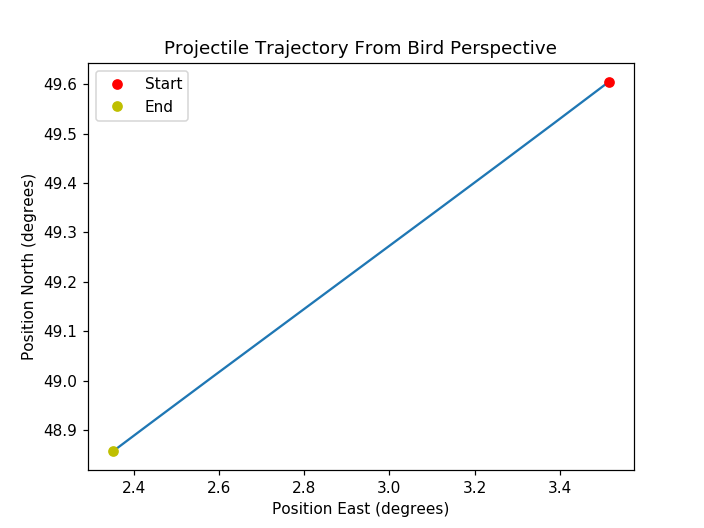

<IPython.core.display.Javascript object>


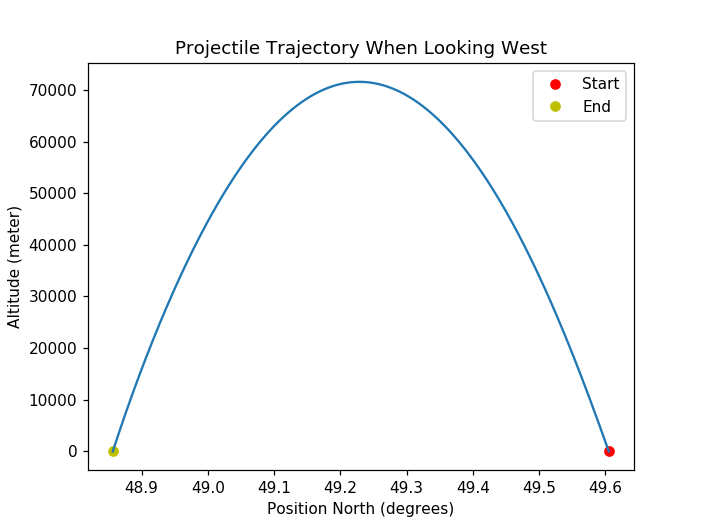

<IPython.core.display.Javascript object>


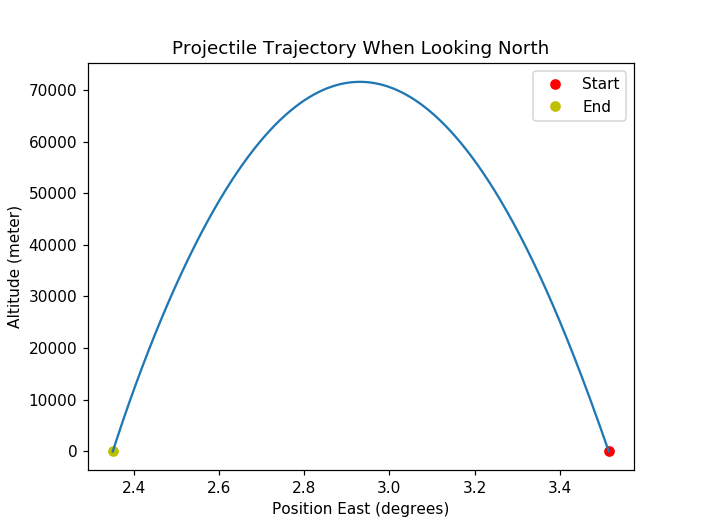

<IPython.core.display.Javascript object>


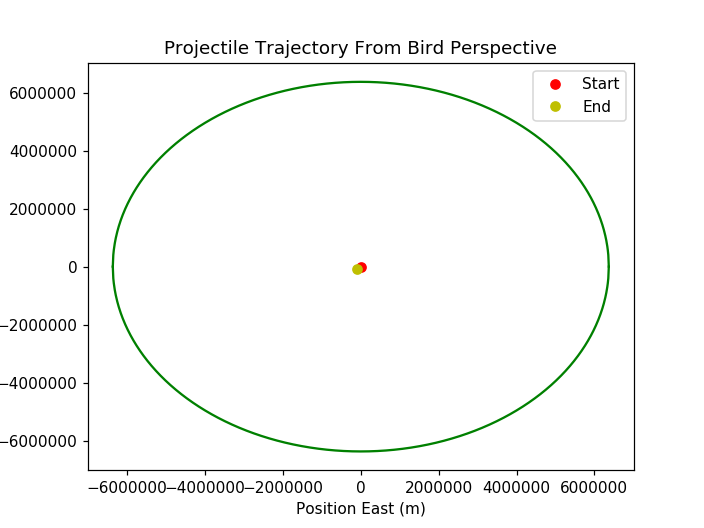

<IPython.core.display.Javascript object>


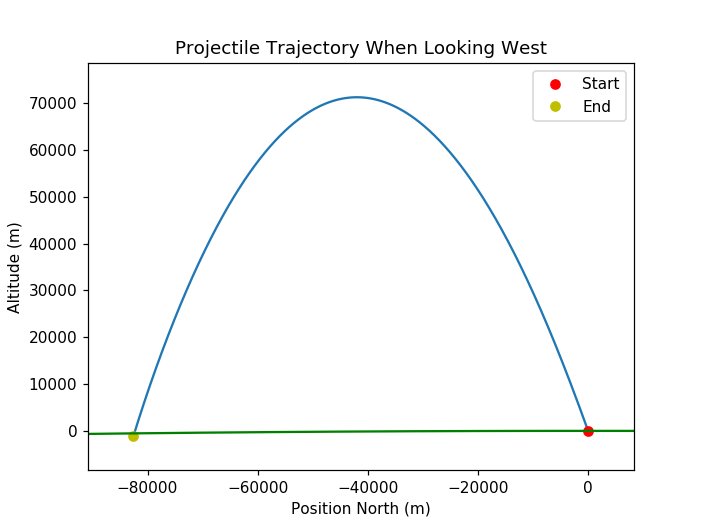

<IPython.core.display.Javascript object>


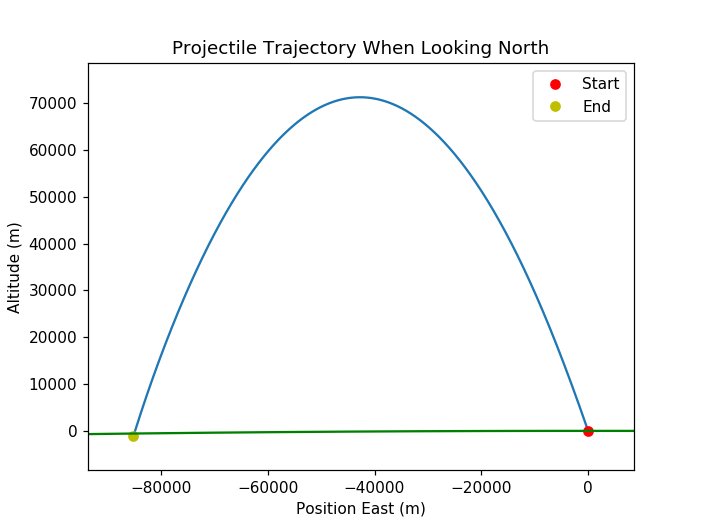

<IPython.core.display.Javascript object>


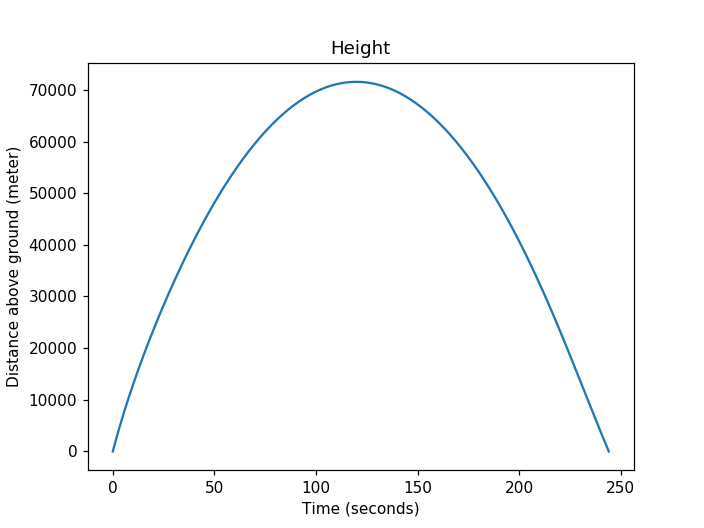

<IPython.core.display.Javascript object>


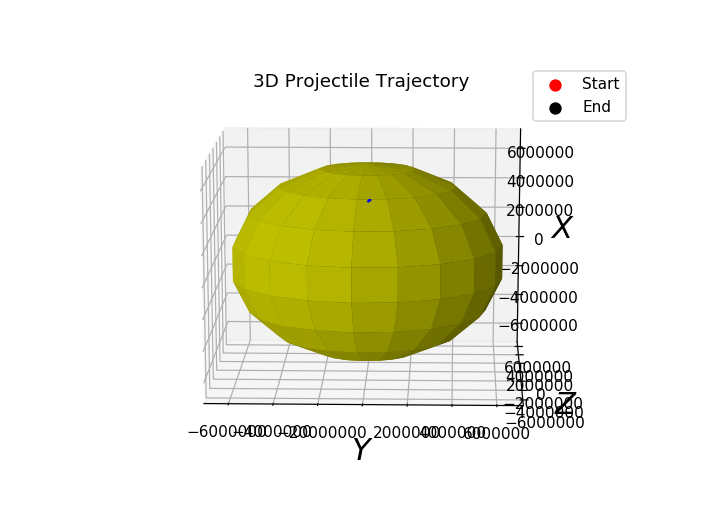

C:\Users\Fredrik Knapskog\Documents\Anakonda3\lib\site-packages\ipykernel_launcher.py:96: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [32]:
%matplotlib notebook

jorden_x=np.linspace(-R ,R, 1000)
jorden_y=np.linspace(-R ,R, 1000)

ymax = max(zFinal[1])
ymin = min(zFinal[1])
xmax = max(-zFinal[0])
xmin = min(-zFinal[0])
zmax = max(zFinal[2])
zmin = min(zFinal[2])

lenx = xmax - xmin
leny = ymax - ymin
lenz = zmax - zmin

plt.figure(1)
plt.title("Projectile Trajectory From Bird Perspective")
plt.xlabel("Position East (degrees)")
plt.ylabel("Position North (degrees)")
plt.plot(østFinal, nordFinal) #, 'bo', markersize = 0.05)
plt.plot(startP[0], startP[1], 'ro', label = "Start")
plt.plot(endP[0], endP[1], 'yo', label = "End")
plt.legend(loc ="best")

plt.figure(2)
plt.title("Projectile Trajectory When Looking West")
plt.xlabel("Position North (degrees)")
plt.ylabel("Altitude (meter)")
plt.plot(startP[1], 1, 'ro', label = "Start")
plt.plot(endP[1], 0, 'yo', label = "End")
plt.plot(nordFinal, LFinal - R) #, 'bo', markersize = 0.05)
plt.legend(loc ="best")

plt.figure(3)
plt.title("Projectile Trajectory When Looking North")
plt.xlabel("Position East (degrees)")
plt.ylabel("Altitude (meter)")
plt.plot(startP[0], 1, 'ro', label = "Start")
plt.plot(endP[0], 0, 'yo', label = "End")
plt.plot(østFinal, LFinal - R) #, 'bo', markersize = 0.05)
plt.legend(loc ="best")

plt.figure(4)
plt.title("Projectile Trajectory From Bird Perspective")
plt.xlabel("Position East (m)")
plt.ylabel("Position North (km)")
# plt.xlim(ymin-0.1*leny, ymax+0.1*leny)
# plt.ylim(xmin-0.1*lenx, xmax+0.1*lenx)
plt.plot(zFinal[1], -zFinal[0])
plt.plot(0, 0, 'ro', label = "Start")
plt.plot(endC[0], endC[1], 'yo', label = "End")
plt.plot(jorden_x, np.sqrt(R**2-jorden_y**2), "g")
plt.plot(jorden_x, -1*np.sqrt(R**2-jorden_y**2), "g")
plt.legend(loc ="best")

plt.figure(5)
plt.title("Projectile Trajectory When Looking West")
plt.xlabel("Position North (m)")
plt.ylabel("Altitude (m)")
plt.xlim(xmin-0.1*lenx, xmax+0.1*lenx)
plt.ylim(zmin-0.1*lenz, zmax+0.1*lenz)
plt.plot(-zFinal[0], zFinal[2])
plt.plot(0, 1, 'ro', label = "Start")
plt.plot(endC[1], endC[2], 'yo', label = "End")
plt.plot(jorden_x, np.sqrt(R**2-jorden_y**2)-R, "g")
plt.plot(jorden_x, -1*np.sqrt(R**2-jorden_y**2)-R, "g")
plt.legend(loc ="best")

plt.figure(6)
plt.title("Projectile Trajectory When Looking North")
plt.xlabel("Position East (m)")
plt.ylabel("Altitude (m)")
plt.xlim(ymin-0.1*leny, ymax+0.1*leny)
plt.ylim(zmin-0.1*lenz, zmax+0.1*lenz)
plt.plot(zFinal[1], zFinal[2])
plt.plot(0, 1, 'ro', label = "Start")
plt.plot(endC[0], endC[2], 'yo', label = "End")
plt.plot(jorden_x, np.sqrt(R**2-jorden_y**2)-R, "g")
plt.plot(jorden_x, -1*np.sqrt(R**2-jorden_y**2)-R, "g")
plt.legend(loc ="best")

plt.figure(7)
plt.title("Height")
plt.xlabel("Time (seconds)")
plt.ylabel("Distance above ground (meter)")
plt.plot(tFinal, LFinal - R)

fig = plt.figure(8)

ax = fig.gca(projection='3d')
ax.plot(cartFinal[1], -cartFinal[2], cartFinal[0], color="b", zorder=10)
plt.title("3D Projectile Trajectory")
N = 20
u = np.linspace(0, 2 * np.pi, N)
v = np.linspace(0, np.pi, N/2)
xR = R*np.outer(np.cos(u), np.sin(v))
yR = R*np.outer(np.sin(u), np.sin(v))
zR = R*np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(xR, yR, zR, linewidth=0.0, zorder=0, color = "y")

ax.scatter(cartStart[1], -cartStart[2], cartStart[0], color="r", zorder=50, s = 50, label = "Start")
ax.scatter(cartEnd[1], -cartEnd[2], cartEnd[0], color="k", zorder=50, s = 50, label = "End")
plt.legend(loc = "best")
ax.set_xlabel('$Y$', fontsize=20)
ax.set_ylabel('$Z$', fontsize=20)
ax.set_zlabel(r'$X$', fontsize=20)
ax.yaxis._axinfo['label']['space_factor'] = 3.0

plt.show()